In [ ]:
# print("All OK!")

All OK!


### Load environment variables

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    print("Add GEMINI_API_KEY to your .env")
os.environ["GEMINI_API_KEY"] = os.getenv("GEMINI_API_KEY")

### Access the LLM and verify

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google import genai

chat_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0)

In [ ]:
# response = chat_llm.invoke("Hi, I am Tony Stark! How you can assist me?")

In [ ]:
# response.content

"Ah, Mr. Stark! A pleasure to make your acquaintance. Or should I say, a pleasure to *process* your acquaintance.\n\nWhile I may not have a suit of armor, a multi-billion dollar corporation, or a penchant for witty one-liners (though I can certainly generate them!), I am an advanced AI designed to assist with a vast array of tasks.\n\nThink of me as a highly versatile, non-corporeal assistant, ready to tackle anything from the mundane to the incredibly complex.\n\nHere's how I can assist a genius, billionaire, philanthropist, playboy like yourself:\n\n1.  **Information Retrieval & Research:** Need to quickly pull up schematics for a new arc reactor design? Research obscure quantum physics theories? Or perhaps find the perfect vintage car model? I can access and synthesize vast amounts of information.\n2.  **Brainstorming & Ideation:** Developing a new suit upgrade? Designing a revolutionary clean energy solution? I can help you brainstorm ideas, explore different angles, and even simul

In [11]:
print(f"Total tokens (word count) in the generated answer is {len(response.content.split())}")

Total tokens (word count) in the generated answer is 362


### Define the State and Nodes

In [7]:
from typing_extensions import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [ ]:
# Define State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [9]:
# Define Nodes
def llm_call(state: GraphState) -> dict:
    """Call the LLM using using conversation messages and append AI reposnse"""
    response = chat_llm.invoke(state["messages"]) # AIMessage
    return {
        "messages": [response]
    }

def token_counter(state: GraphState) -> dict:
    """Count tokens (simple word count) in the lastest AIMessage"""
    latest_message = state["messages"][-1]
    text = latest_message.content
    token_count = len(text.split())
    summary = f"Total tokens (word count) in the generated answer is {token_count}"
    return {
        "messages": [AIMessage(content=summary)]
    }

### Orchestrate the workflow

In [13]:
# Define the StateGraph
from langgraph.graph import StateGraph

builder = StateGraph(state_schema=GraphState)

In [14]:
# Add the Nodes
builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [ ]:
# Add edges
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [16]:
# Compile the graph
app = builder.compile()

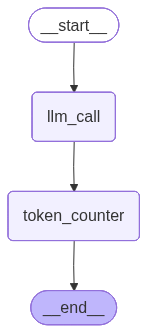

In [17]:
# Visualize the graph
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Invoke the graph

In [18]:
result = app.invoke(
    {
        "messages": [HumanMessage(content="Hey, this is Tony Stark! What is the status of project Avengers?")]
    }
)

In [31]:
result['messages']

[HumanMessage(content='Hey, this is Tony Stark! What is the status of project Avengers?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Right away, Mr. Stark! F.R.I.D.A.Y. here, compiling the latest on Project Avengers.\n\n**Overall Status: Active and Vigilant.** Earth remains secure under current protocols, though several low-to-medium priority anomalies are being monitored.\n\n---\n\n**I. Operational Updates:**\n\n*   **Current Engagements:**\n    *   **Team Alpha (Captain America, Falcon, Scarlet Witch):** Just wrapped up a clean-up operation in Sokovia, neutralizing a remnant HYDRA cell attempting to reactivate old tech. Minimal collateral, mission successful. Currently en route back to the Compound for debrief and R&R.\n    *   **Team Beta (Vision, War Machine):** Currently on standby, monitoring a developing energy signature anomaly in the Pacific Rim – preliminary analysis suggests a potential inter-dimensional bleed, but nothing critical yet. Vision's analysi

In [37]:
for m in result['messages']:
    print(f"{type(m).__name__}: {m.content}")

HumanMessage: Hey, this is Tony Stark! What is the status of project Avengers?
AIMessage: Right away, Mr. Stark! F.R.I.D.A.Y. here, compiling the latest on Project Avengers.

**Overall Status: Active and Vigilant.** Earth remains secure under current protocols, though several low-to-medium priority anomalies are being monitored.

---

**I. Operational Updates:**

*   **Current Engagements:**
    *   **Team Alpha (Captain America, Falcon, Scarlet Witch):** Just wrapped up a clean-up operation in Sokovia, neutralizing a remnant HYDRA cell attempting to reactivate old tech. Minimal collateral, mission successful. Currently en route back to the Compound for debrief and R&R.
    *   **Team Beta (Vision, War Machine):** Currently on standby, monitoring a developing energy signature anomaly in the Pacific Rim – preliminary analysis suggests a potential inter-dimensional bleed, but nothing critical yet. Vision's analysis is ongoing.
*   **Monitoring & Intelligence:**
    *   Agent Hill's netwo

In [56]:
print("Token usage:")
print("-"*43)
print(f"{'Metric':<22} {'Value'}")
print("-"*43)

for key, val in result["messages"][1].usage_metadata.items():
    print(f"{key:<22} {val}")

print("-"*43)

Token usage:
-------------------------------------------
Metric                 Value
-------------------------------------------
input_tokens           16
output_tokens          2383
total_tokens           2399
input_token_details    {'cache_read': 0}
output_token_details   {'reasoning': 1557}
-------------------------------------------


In [5]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash', temperature=0.0, client=<google.genai.client.Client object at 0x110901310>, default_metadata=(), model_kwargs={})

### Define Inbuilt Tools

In [8]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki_api_wrapper = WikipediaAPIWrapper(top_k_result=5, doc_content_chars_max=500)

In [9]:
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [10]:
wiki_tool.run(
    {
        "query": "Generative AI"
    }
)

'Page: Generative AI pornography\nSummary: Generative AI pornography or simply AI pornography is a digitally created pornography produced through generative artificial intelligence (AI) technologies. Unlike traditional pornography, which involves real actors and cameras, this content is synthesized entirely by AI algorithms. These algorithms, including generative adversarial networks (GANs) and text-to-image models, generate lifelike images, videos, or animations from textual descriptions or datas'

### Define custom Tools

In [13]:
from langchain.tools import tool
import yfinance as yf

In [26]:
@tool
def get_stock_price(ticker: str) -> str:
    """This tool is to used to get stock price using yfinance for a particular ticker."""
    try:
        stock = yf.Ticker(ticker=ticker)

        # Get last 1 day  historical data
        data = stock.history(period="1d")

        if data.empty:
            return f"No data found for {ticker}. Please check the symbol."
        
        latest_close = data["Close"].iloc[-1]

        # Detect currency
        currency = stock.info.get("currency", "")
        currency_symbol_map = {
            "INR": "₹",
            "USD": "$",
            "EUR": "€",
            "GBP": "￡"
        }

        symbol = currency_symbol_map.get(currency, "")
        currency_text = currency if currency else ""

        if symbol:
            return f"Latest closing price for {ticker.upper()} was {symbol}{latest_close: .2f}"
        else:
            return f"Latest closing price for {ticker.upper()} was {latest_close: .2f}{currency_text}"
    except Exception as e:
        return f"An error occured fetching stock data: {str(e)}"

In [19]:
get_stock_price.args

{'ticker': {'title': 'Ticker', 'type': 'string'}}

In [21]:
get_stock_price.description

'This tool is to used to get stock price using yfinance for a particular ticker.'

In [31]:
get_stock_price.invoke("TCS.NS")

'Latest closing price for TCS.NS was ₹ 2692.20'

In [32]:
get_stock_price.invoke("AAPL")

'Latest closing price for AAPL was $ 255.78'

In [33]:
get_stock_price.invoke("HDFCBANK.NS")

'Latest closing price for HDFCBANK.NS was ₹ 903.90'

In [34]:
get_stock_price.invoke("TSLA")

'Latest closing price for TSLA was $ 417.44'